In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-set/mnist_test.csv
/kaggle/input/mnist-set/mnist_train.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
mnist_test = pd.read_csv('/kaggle/input/mnist-set/mnist_test.csv', header=None)
mnist_train = pd.read_csv('/kaggle/input/mnist-set/mnist_train.csv', header=None)

In [6]:
X_train, y_train = mnist_train.iloc[:, 1:785], mnist_train.iloc[:, :1]
X_test, y_test = mnist_test.iloc[:, 1:785], mnist_test.iloc[:, :1], 
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

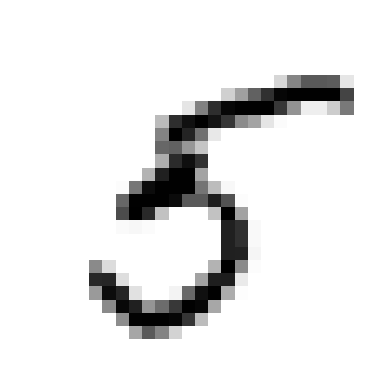

In [7]:
sample_digit = np.array(X_train.iloc[10111])
sample_image = sample_digit.reshape(28,28)
plt.imshow(sample_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y_train_5 = (np.array((y_train == 5))).flatten()
y_test_5 = (np.array((y_test == 5))).flatten()


## Binary Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=69)
sgd_model.fit(X_train, y_train_5)

SGDClassifier(random_state=69)

In [10]:
sgd_model.predict(sample_digit.reshape(1,784))


array([ True])

In [11]:
# Trying cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

In [12]:
"""
Here we have split the Training data into 3 groups and at each iteration we set a new training and cross val set.
X_train_folds and y_train_folds make up the (sub) training set of the Training Set
X_test_folds and y_test_folds make up the the cross_val set index of Training Set
"""
for train_index, test_index in skfolds.split(X_train, y_train_5):
    cloned_clf = clone(sgd_model)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    cloned_clf.fit(X_train_folds, y_train_folds)
    y_pred = cloned_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96685
0.9522
0.9585


In [13]:
"""
Using Sci-Kit's Kfold
"""

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_model, X_train, y_train.flatten(), cv=3, scoring='accuracy')

array([0.87495, 0.87085, 0.8777 ])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_model, X_train, y_train_5.flatten(), cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53054,  1525],
       [  973,  4448]])

In [16]:
# Calcualting Precision and Recall
from sklearn.metrics import precision_score, recall_score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")

Precision: 0.7446844131927005
Recall: 0.8205128205128205


In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7807618044584869

In [18]:
y_scores = cross_val_predict(sgd_model, X_train, y_train_5, cv=3, method="decision_function")

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

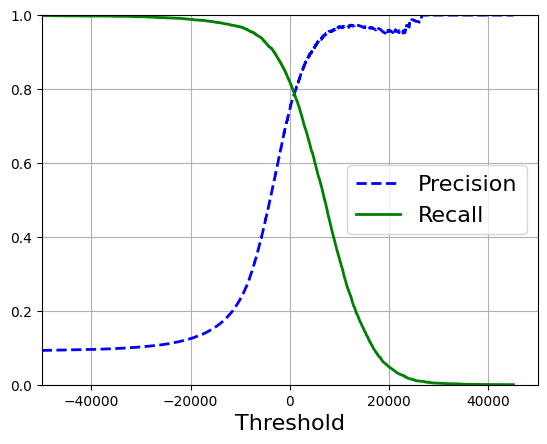

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

In [21]:
# Aiming for 88% preicision 
threshold_88_precision = thresholds[np.argmax(precision >= 0.88)]

In [22]:
y_train_pred_88 = (y_scores >= threshold_88_precision)
precision_score(y_train_5, y_train_pred_88)

0.8801996672212978

In [23]:
recall_score(y_train_5, y_train_pred_88)

0.6830843017893378

In [26]:
# Plotting ROC curve

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

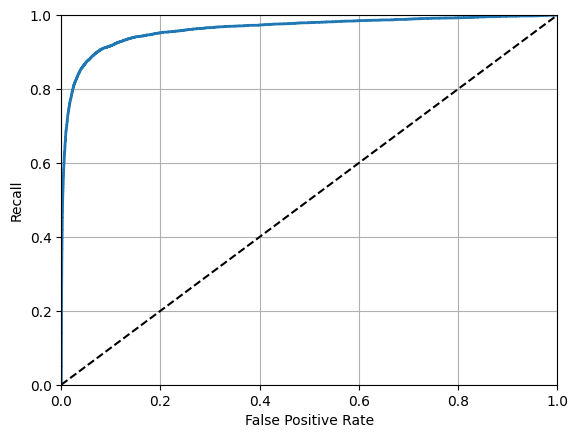

In [31]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate", fontsize="10")
    plt.ylabel("Recall", fontsize="10")
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
print(f"AUC score for SGD: {roc_auc_score(y_train_5, y_scores)}")

AUC score for SGD: 0.962639382424524


In [32]:
# Trying Random Forest Model
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=69)
y_prob_forest = cross_val_predict(forest_model, X_train, y_train_5.flatten(), cv=3, method="predict_proba")

In [39]:
y_scores_forest = y_prob_forest[:, 1] #Positive Class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

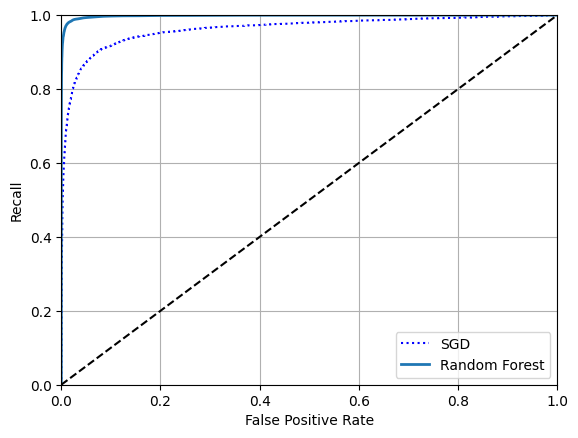

In [42]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [48]:
print(f"AUC score for Random Forest: {roc_auc_score(y_train_5, y_scores_forest)}")

AUC score for Random Forest: 0.9983154768905237


In [50]:
y_train_pred_forest = cross_val_predict(forest_model, X_train, y_train_5.flatten(), cv=3)

In [51]:
print(f"Precision: {precision_score(y_train_5, y_train_pred_forest)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred_forest)}")

Precision: 0.98989898989899
Recall: 0.8677365799667958


## Multiclass Classification

In [54]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train.flatten())
svm_model.predict([sample_digit])

array([5])

In [55]:
svm_model.decision_function([sample_digit])

array([[4.83448991, 1.73185162, 0.7038713 , 8.27452779, 3.74552925,
        9.31789846, 2.73405492, 0.69791487, 7.28036142, 4.86779426]])

In [56]:
"""
Using SGD for multiclass classification with normalised values
"""

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [62]:
cross_val_score(sgd_model, X_train_scaled, y_train.flatten(), cv=3, scoring="accuracy")

KeyboardInterrupt: 

In [64]:
conf_matrix = confusion_matrix(y_train, y_train_pred_multi)
conf_matrix

array([[5607,    0,   25,    8,    9,   56,   37,    6,  173,    2],
       [   0, 6420,   44,   24,    5,   48,    4,    9,  175,   13],
       [  30,   29, 5297,   93,   71,   29,   71,   42,  284,   12],
       [  25,   18,  130, 5275,    3,  231,   27,   43,  300,   79],
       [  11,   14,   53,   12, 5241,   13,   44,   27,  249,  178],
       [  29,   17,   33,  173,   56, 4568,   77,   17,  379,   72],
       [  31,   16,   49,    2,   41,  100, 5576,    3,   99,    1],
       [  20,   10,   55,   33,   53,   14,    3, 5723,  127,  227],
       [  18,   70,   52,   96,    5,  154,   29,   11, 5358,   58],
       [  24,   20,   31,   67,  122,   44,    1,  183,  260, 5197]])

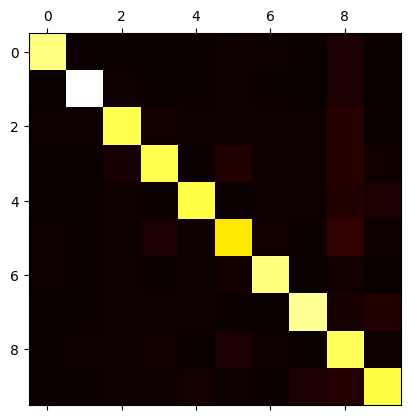

In [66]:
plt.matshow(conf_matrix, cmap=plt.cm.hot)
plt.show()